# Colorizing the Russian Empire

### Goal: automatically produce a color image from the digitized Prokudin- Gorskii glass plate images with as few visual artifacts as possible.
###### There are four parts to this code
1. Image preprocessing
2. Align image function
3. For .jpg
4. For .tif

In [1]:
import numpy as np
import matplotlib.pyplot as plt #show images
import skimage.io as skio #for read images
import glob #for read images
import os #for read images
import time #for test time
# import skimage.transform as sktr #test down_local_mean
# from scipy import ndimage #test sobel

# Image preprocessing

In [2]:
def preprocessing(imgPath):
    img = skio.imread(imgPath)
    img.astype(float)
    if imgPath[-3:] == 'tif':
        img = img / 65535
    else:
        img = img / 255
    
    height = img.shape[0] // 3
    
    r = img[2 * height: 3 * height]
    g = img[height: 2 * height]
    b = img[:height]

    r = crop(r)
    b = crop(b)
    g = crop(g)
    
    output = np.dstack([r,g,b])
    
    return img, output

def crop(img, c = 0.1):
    h, w = img.shape
    h0, h1 = int(c*h), int((1-c)*h)
    w0, w1 = int(c*w), int((1-c)*w)
    
    return img[h0:h1, w0:w1]

* show the preprocessing result

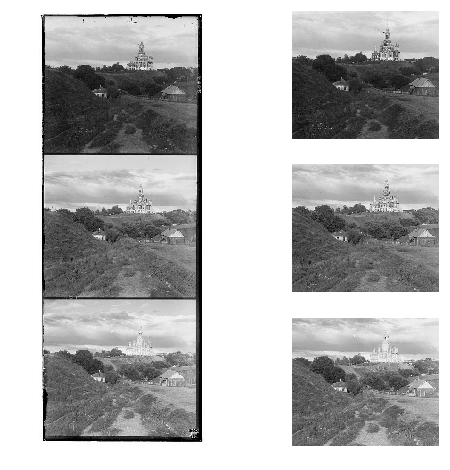

In [3]:
images = glob.glob('task3_colorizing\\*.jpg')
img, prepro = preprocessing(images[0])
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(img, plt.cm.gray)
plt.axis('off')  
plt.subplot(322)
plt.imshow(prepro[:,:,2], plt.cm.gray) #b
plt.axis('off')  
plt.subplot(324)
plt.imshow(prepro[:,:,1], plt.cm.gray) #g
plt.axis('off')  
plt.subplot(326)
plt.imshow(prepro[:,:,0], plt.cm.gray) #r
plt.axis('off');

# Align image function

In [4]:
#align image just using ssd, which may cause massive calculation in .tif, return a image ndarray:(height, weight, 3)
def alignedImg(img, size):
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    r_sh = shift(r, b, size)
    g_sh = shift(g, b, size)
    

    aligned_r = np.roll(r, r_sh[0], axis=0)
    aligned_r = np.roll(aligned_r, r_sh[1], axis=1)
    aligned_g = np.roll(g, g_sh[0], axis=0)
    aligned_g = np.roll(aligned_g, g_sh[1], axis=1)
    img = np.dstack([aligned_r,aligned_g,b])
    return img

#A->B, return the shift size
def shift(A, B, size=15): 
    min_ssd = float("inf")
    shift = [0, 0]
    for i in range(-size, size):
        for j in range(-size, size):
            newA = np.roll(A, i, axis=0) #---
            newA = np.roll(newA, j, axis=1) # 
            ssdRes = ssd(newA, B)
            if min_ssd > ssdRes:
                min_ssd = ssdRes
                shift = [i, j]
    return shift

def ssd(A, B):
    return np.sum((A - B)**2)

# For .jpg
* show result

img size: (272, 312)


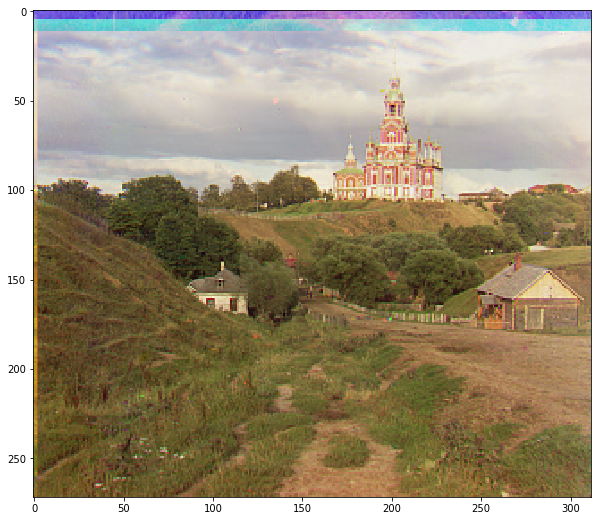

img size: (272, 312)


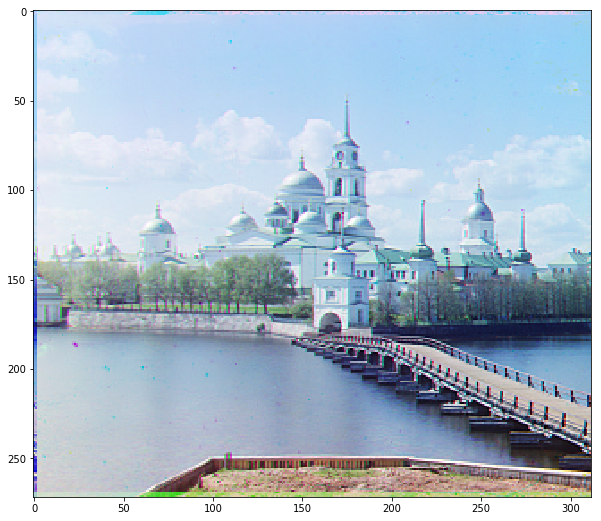

img size: (272, 316)


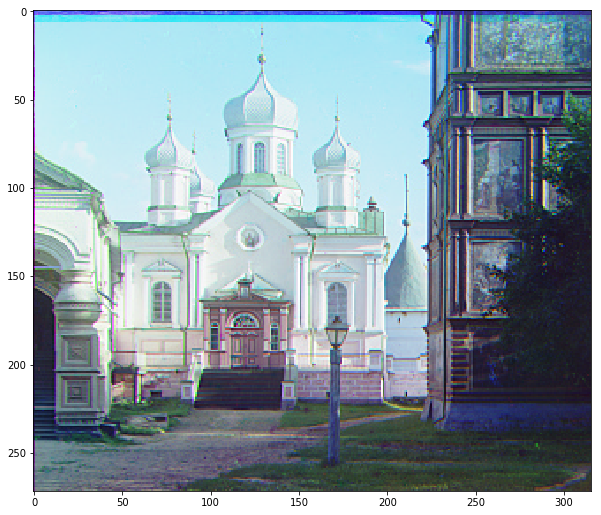

img size: (272, 317)


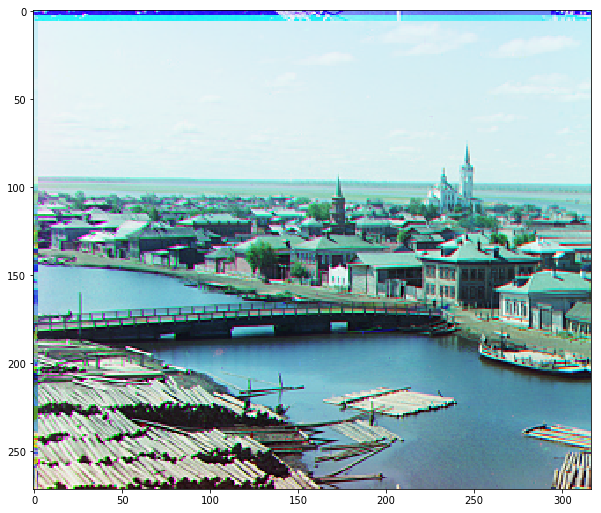

In [5]:
jpg_images = glob.glob('task3_colorizing\\*.jpg')
for i in jpg_images:
    old, img = preprocessing(i)
    imgAligned = alignedImg(img, 15)
    plt.figure(figsize=(10, 10))
    print('img size:', imgAligned.shape[:-1])
    plt.imshow(imgAligned);
    plt.show()

# for .tif

In [7]:
def pyramidRoll(img, f=20):
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    original_r = r.copy()
    original_g = g.copy()
    original_b = b.copy()
    
    print('start do sobel...')
    t1 = time.time()
#     r = ndimage.sobel(r)
#     g = ndimage.sobel(g)
#     b = ndimage.sobel(b)
    r = sobel_new_version(r)
    g = sobel_new_version(g)
    b = sobel_new_version(b)
    t2 = time.time()
    print("sobelTime=", t2-t1)
    
    
    print('\nstart run pyramid rolling...')
    rollT1 = time.time()
    window_size = r.shape[0] // f // 5
    gShift = [0, 0]
    rShift = [0, 0]
    while (f > 0):
        t1 = time.time()
#         down_b = sktr.downscale_local_mean(b, (f, f))
#         down_g = sktr.downscale_local_mean(g, (f, f))
#         down_r = sktr.downscale_local_mean(r, (f, f))
        down_b = down_local_mean(b, f)
        down_g = down_local_mean(g, f)
        down_r = down_local_mean(r, f)
        t2 = time.time()
        print('f = {}, down_local_mean = {}'.format(f, t2-t1))
        
        g2b = shift(down_g, down_b, window_size)
        r2b = shift(down_r, down_b, window_size)

        for i in range(2):
            gShift[i] += g2b[i] * f
            rShift[i] += r2b[i] * f
            
        for i in range(2):
            g = np.roll(g, g2b[i] * f, axis=i)
            r = np.roll(r, r2b[i] * f, axis=i)
            
        f //= 2
        window_size //= 2
        
    for i in range(2):
        original_g = np.roll(original_g, gShift[i], axis=i)
        original_r = np.roll(original_r, rShift[i], axis=i)

    img_out = np.dstack([original_r, original_g, original_b])
    rollT2 = time.time()
    print('rollTime = {}\n\n'.format(rollT2-rollT1))
    
    return img_out

def down_local_mean(img, f):
    in_row, in_col = img.shape
    out_row, out_col = in_row // f, in_col // f
    result = np.zeros([out_row, out_col])

    
    for r in range(out_row):
        for c in range(out_col):
            result[r,c] = np.sum(img[r*f:r*f+f, c*f:c*f+f]) // (f*f)
    return result

def sobel_old_version(img):
    num_row, num_col = img.shape
    
    #PADDING
    img = np.hstack([img[:, 0].reshape(-1,1), img, img[:, -1].reshape(-1,1)])
    img = np.vstack([img[0, :], img, img[-1, :]])
    
    sobel_i = [-1, 0, 1]
    sobel_j = [1, 2, 1]
    
    sobel_x = np.zeros([num_row, num_col]) #sobel_i * sobel_j
    sobel_y = np.zeros([num_row, num_col]) #sobel_j * sobel_i

    xtmp_sum = img.copy()
    ytmp_sum = img.copy()
    for i in range(num_row+2):
        for j in range(1, num_col+1):
            xtmp_sum[i, j] = np.sum(img[i, j-1:j+2] * sobel_i)
            ytmp_sum[i, j] = np.sum(img[i, j-1:j+2] * sobel_j)
    for i in range(1, num_row+1):
        for j in range(1, num_col+1):
            sobel_x[i-1, j-1] = np.sum(xtmp_sum[i-1:i+2, j] * sobel_j)
            sobel_y[i-1, j-1] = np.sum(ytmp_sum[i-1:i+2, j] * sobel_i)
    
    result = sobel_x + sobel_y
#     result = np.abs(sobel_x) + np.abs(sobel_y)
#     result = np.sqrt(sobel_x**2 + sobel_y**2)
    
    return result
    
def sobel_new_version(img):
    sobel_x = img[:,2:] - img[:,:-2]
    sobel_x = sobel_x[:-2] + sobel_x[2:] + 2*sobel_x[1:-1]

    sobel_y = img[:-2] + img[2:] + 2*img[1:-1]
    sobel_y = sobel_y[:,2:] - sobel_y[:,:-2]

    result = sobel_x + sobel_y
#     result = np.abs(sobel_x) + np.abs(sobel_y)
#     result = np.sqrt(sobel_x**2 + sobel_y**2)

    return result

* show result

img size: (2568, 2961)


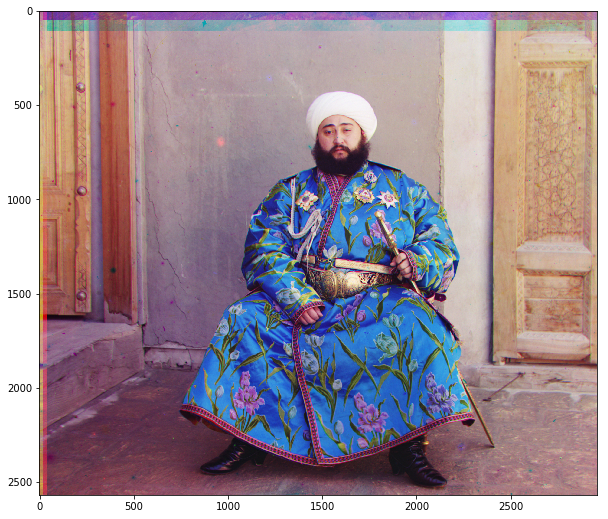

img size: (2595, 2992)


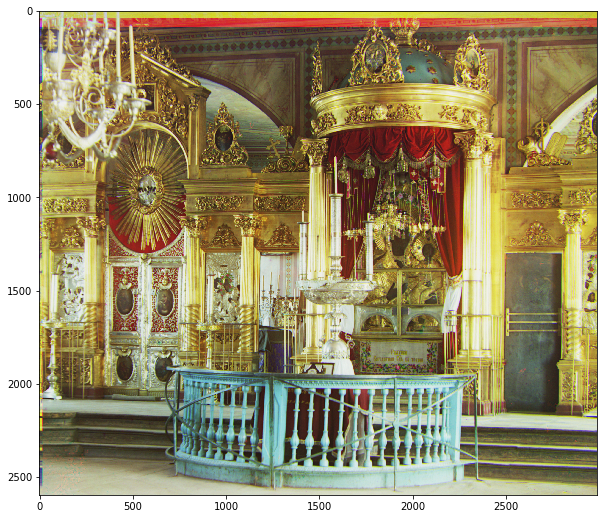

img size: (2569, 3008)


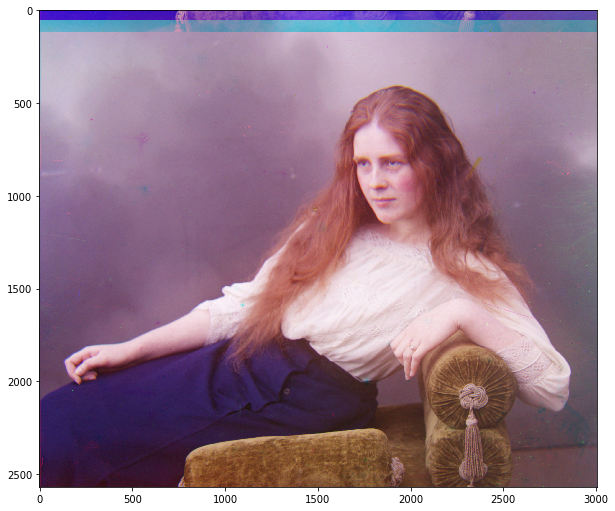

img size: (2592, 3016)


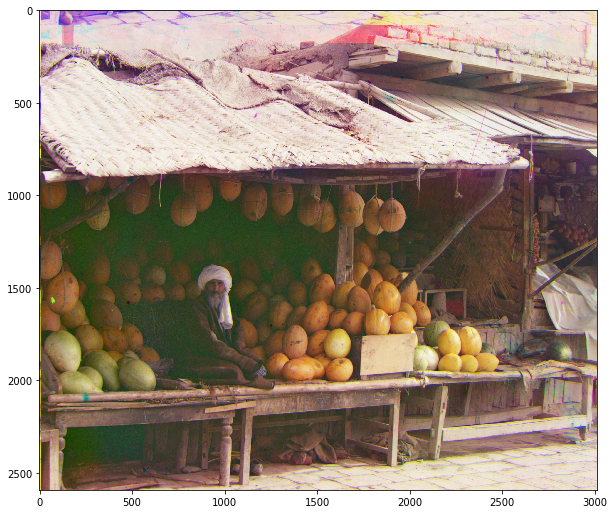

img size: (2572, 3024)


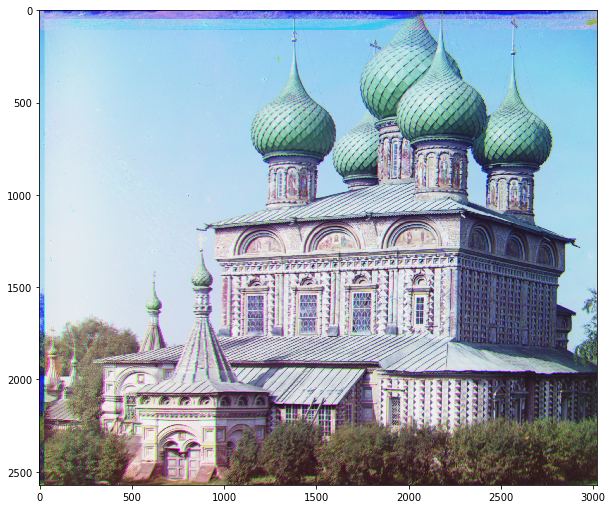

img size: (2568, 2971)


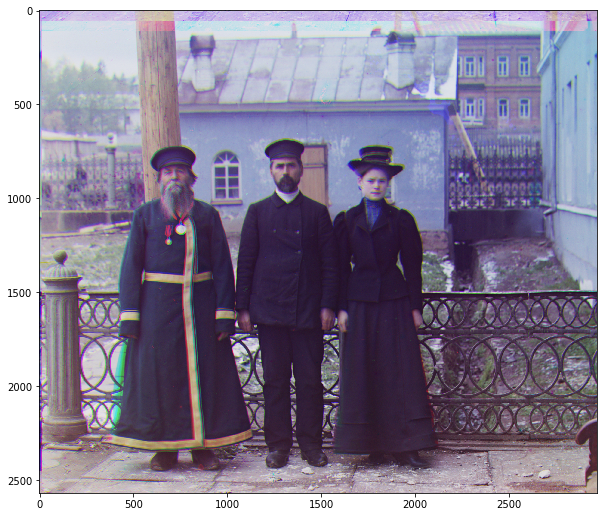

img size: (2591, 2992)


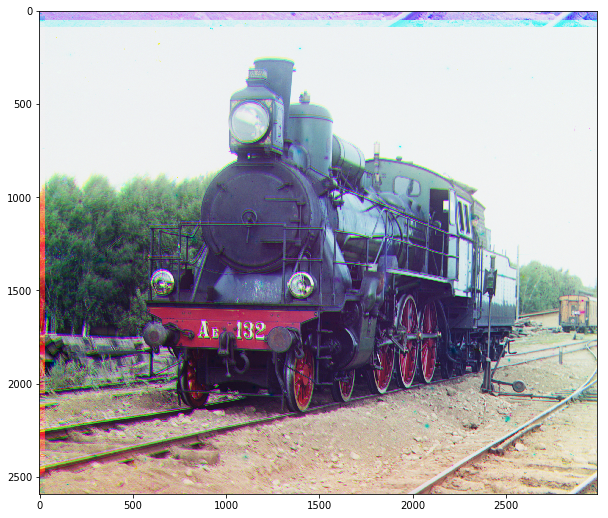

img size: (2616, 3056)


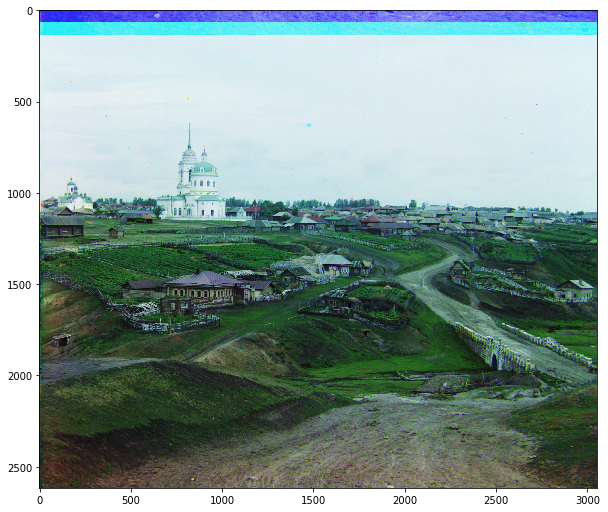

img size: (2568, 2992)


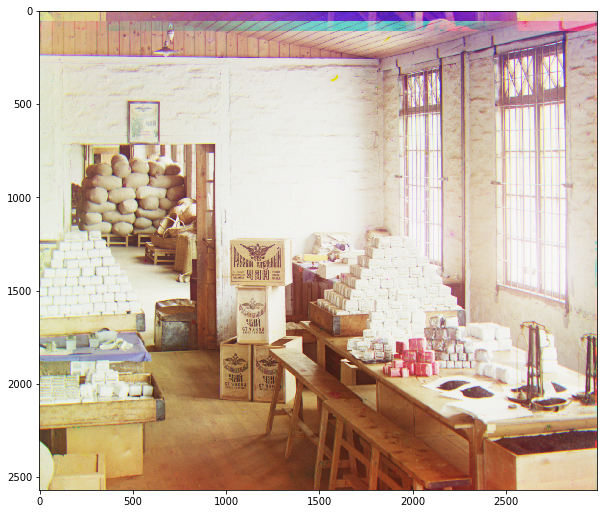

In [8]:
tif_images = glob.glob('task3_colorizing\\*.tif')
for i in tif_images:
    old, img = preprocessing(i)
    npy = i.replace('.tif', '.npy')
    if os.path.isfile(npy):
        imgAligned = np.load(npy)
    else:
        imgAligned = pyramidRoll(img, 20)
        np.save(npy, imgAligned)
        
    plt.figure(figsize=(10, 10))
    print('img size:', imgAligned.shape[:-1])
    plt.imshow(imgAligned);
    plt.show()